# Assignment 1: Bucharest Housing Dataset





## Dataset Description
In the dataset linked below you have over three thousand apartments listed for sale on the locally popular website *imobiliare.ro*. Each entry provides details about different aspects of the house or apartment:
1. `Nr Camere` indicates the number of rooms;
2. `Suprafata` specifies the total area of the dwelling;
3. `Etaj` specifies the floor that the home is located at;
4. `Total Etaje` is the total number of floors of the block of flats;
5. `Sector` represents the administrative district of Bucharest in which the apartment is located;
6. `Pret` represents the listing price of each dwelling;
7. `Scor` represents a rating between 1 and 5 of location of the apartment. It was computed in the following manner by the dataset creator:


The initial dataset included the address of each flat;

An extra dataset was used, which included the average sales price of dwellings in different areas of town;

Using all of these monthly averages, a clusterization algorithm grouped them into 5 classes, which were then labelled 1-5;

You can think of these scores as an indication of the value of the surrounding area, with 1 being expensive, and 5 being inexpensive.

Dataset Source: [kaggle.com/denisadutca](https://www.kaggle.com/denisadutca/bucharest-house-price-dataset/kernels)




## Assignment

To complete this assignment, you must:
1. Get the data in a PyTorch-friendly format;
2. Predict the `Nr Camere` of each dwelling, treating it as a **classification** problem. Choose an appropriate loss function;
3. Predict the `Nr Camere` of each dwelling, treating it as a **regression** problem. Choose an appropriate loss function;
4. Compare the results of the two approaches, displaying the Confusion Matrix for the two, as well as any comparing any other metrics you think are interesting (e.g. MSE). Comment on the results;
5. Choose to predict a feature more suitable to be treated as a **regression** problem, then successfully solve it.
6. What values should the loss have when the predictions are random (when your network is not trained at all)?
7. Don't forget to split the dataset in training and validation.




## Hints
1. It might prove useful to link your Google Drive to this Notebook. See the code cell below;
2. You might want to think of ways of preprocessing your data (e.g. One Hot Encoding, etc.);
3. Don't be afraid of using text cells to actually write your thoughts about the data/results. Might prove useful at the end of the semester when you'll need to walk us through your solution 😉.



## Deadline
March 18, 2021, 23:59

**Punctaj maxim:** 2 puncte.

Depunctarea este de 0.25 puncte pe zi intarziata. Dupa mai mult de 4 zile intarziere, punctajul maxim care se poate obtine ramane 1 punct.

Trimite notebookul si datasetul intr-o arhiva `NumePrenume_Grupa_Tema1.zip` aici: https://forms.gle/MGrLvehEjmtWmQZP7 (la sustinerea temei, vei rula codul din arhiva).

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Bucharest_HousePriceDataset.csv to Bucharest_HousePriceDataset.csv


In [4]:
!pip install torchviz
from functools import partial
from IPython.display import HTML
import math
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchviz
from typing import Iterator
import pandas as pd

In [5]:
dataframe = pd.read_csv("Bucharest_HousePriceDataset.csv")
print(dataframe)

      Nr Camere  Suprafata  Etaj  Total Etaje  Sector  Scor    Pret
0             4     108.00     2            3       4     5   83000
1             1      41.00     1            8       1     1   39900
2             3      63.52     1            3       2     3   84900
3             1      33.00     3           10       5     1   45500
4             2      62.00     5            9       5     5   54900
...         ...        ...   ...          ...     ...   ...     ...
3524          3     102.00     2            5       1     1  189000
3525          4      96.00     1            3       3     2  200000
3526          1      35.00     1            3       4     5   47000
3527          2      60.00     6            7       1     2   89500
3528          3      80.00     3            5       1     2  139000

[3529 rows x 7 columns]


#### Data

Now, the data is read and will be transformed to feature vectors.

We will predict the 'Nr camere' using only the features that seem to be correlated.

'Etaj' and 'Total etaje' should not be correlated to 'Nr Camere' 

Suprafata, Pret - very important features
Sector - less important featur 


We will scale the data and split in train/val.
Also, the values for 'Nr Camere' will be transposed from 1 to 9 to 0 to 8). This must be done only once, for both classification and regression problems

In [116]:


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

new_dataframe = dataframe[['Suprafata', 'Sector', 'Scor', 'Pret']]
feature_vector = new_dataframe.to_numpy()

std_scale = StandardScaler().fit(feature_vector)
feature_vector = std_scale.transform(feature_vector)


label_vector = dataframe[['Nr Camere']].to_numpy() - 1
X_train, X_val, Y_train, Y_val = train_test_split(feature_vector, label_vector, test_size = 0.15, shuffle='true')

print("Data scaling and splitting in train and validation done")

def plot_loss(loss, label, color='blue'):
    plt.plot(loss, label=label, color=color)
    plt.legend()


Data scaling and splitting in train and validation done


### Multilayer neural network for classfication

*Input size* :  (number of features that should be correlated to 'Nr camere' : 'Suprafata', 'Sector', 'Pret', 'Scor')

*Hidden layers of size* : 108, 108, 216, 108

*Output size* : 9 (number of different values for 'Nr Camere'). The dataset contains apartments with 1 to 9 values for this column

*The neural network* will return 9 probabilities, the highest one will indicate the most probable answer for the input example. The loss will be CrossEntropy and the chosen optimizer is Adadgrad with adaptive learning rate.


In [118]:
class MultiLayerNNClassifier(nn.Module):
    def __init__(self, 
                 input_size: int, 
                 hidden_size1: int, 
                 hidden_size2: int, 
                 hidden_size3: int,
                 hidden_size4: int,
                 output_size: int):
      
        super().__init__()

        self._layer1 = nn.Linear(input_size, hidden_size1)
        self._layer2 = nn.Linear(hidden_size1, hidden_size2)
        self._layer3 = nn.Linear(hidden_size2, hidden_size3)
        self._layer4 = nn.Linear(hidden_size3, hidden_size4)
        self._layer5 = nn.Linear(hidden_size4, output_size)
        
        self._relu = nn.ReLU()
   
    def forward(self, input_layer):

        out_layer1 = self._relu(self._layer1(input_layer))
        out_layer2 = self._layer2(out_layer1)
        out_layer3 = self._layer3(out_layer2)
        out_layer4 = self._layer4(out_layer3)
        out_layer5 = self._layer5(out_layer4)

        return out_layer5

#### Neural network classifier train


In [152]:


model = MultiLayerNNClassifier(4, 108, 108, 216, 108, 9)

print(model)

num_epochs = 750
print_every = 100

train_loss = []
val_loss = []

optim = torch.optim.Adagrad(model.parameters())
criterion = nn.CrossEntropyLoss()

for i in range(num_epochs):

    model.train()
    optim.zero_grad()
    output = model(torch.tensor(X_train, dtype = torch.float32))

    loss = criterion(output, torch.tensor(Y_train, dtype = torch.int64).flatten())
    loss.backward()
    optim.step()
    
    train_loss.append(loss.detach().numpy())

    if i % print_every == 0 or i == num_epochs - 1:
        print(f'EPOCH {i}:')
        print(f'loss = {loss.item()}')

    model.eval()
    with torch.no_grad():
        output = model(torch.tensor(X_val, dtype = torch.float32))
        validation_loss = F.cross_entropy(output, torch.tensor(Y_val, dtype = torch.int64).flatten())
        val_loss.append(validation_loss)

MultiLayerNNClassifier(
  (_layer1): Linear(in_features=4, out_features=108, bias=True)
  (_layer2): Linear(in_features=108, out_features=108, bias=True)
  (_layer3): Linear(in_features=108, out_features=216, bias=True)
  (_layer4): Linear(in_features=216, out_features=108, bias=True)
  (_layer5): Linear(in_features=108, out_features=9, bias=True)
  (_relu): ReLU()
)
EPOCH 0:
loss = 2.1788957118988037
EPOCH 100:
loss = 0.558444082736969
EPOCH 200:
loss = 0.5389026403427124
EPOCH 300:
loss = 0.5283981561660767
EPOCH 400:
loss = 0.5216827392578125
EPOCH 500:
loss = 0.5162706971168518
EPOCH 600:
loss = 0.5127044916152954
EPOCH 700:
loss = 0.5089181065559387
EPOCH 749:
loss = 0.5099955797195435


#### Validation and training accuracy on classifier

Training accuracy: 0.7972657680511475
Validation accuracy: 0.7924528121948242
Confusion matrix for validation :

[[ 39  12   0   0   0   0   0]
 [  5 209  29   1   0   0   0]
 [  0  17 161   2   1   0   0]
 [  0   0  34  10   0   0   0]
 [  0   0   3   5   0   0   0]
 [  0   0   0   1   0   0   0]
 [  0   0   0   0   0   0   1]]



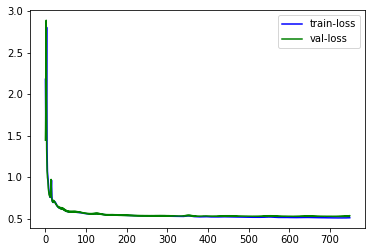

In [153]:

def acuraccy_classifier(X, Y):
    with torch.no_grad():
      Y_pred = torch.argmax(model(torch.tensor(X, dtype = torch.float32)), dim=-1)
    
    confusion_mat = confusion_matrix(Y, Y_pred)
    Y_accuracy = torch.sum(Y_pred == torch.tensor(Y, dtype = torch.int64).flatten()) / Y_pred.shape[0]
    return Y_accuracy, confusion_mat



Y_accuracy_train, confusion_mat_train = acuraccy_classifier(X_train, Y_train)
print('Training accuracy: {}'.format(Y_accuracy_train))


Y_accuracy_val, confusion_mat_val = acuraccy_classifier(X_val, Y_val)
print('Validation accuracy: {}'.format(Y_accuracy_val))

print('Confusion matrix for validation :')
print()
print(confusion_mat_val)
print()

plot_loss(train_loss, 'train-loss', color='blue')
plot_loss(val_loss, 'val-loss', color='green')

### Multilayer neural network for regression

*Input size* : 4 (same as for classfication, number of features that should be correlated to 'Nr camere' : 'Suprafata', 'Sector', 'Pret', 'Scor'

*Hidden layers of size* : 480, 54, 58

*Output size* : 1 (this time, the neural network will return a predict value of type **double**, which will indicate the prediction for 'Nr camere'). This afterwards must be round. 

The loss for the regressor is MSE and the  chosen optimizer is Adam.


In [154]:
class MultiLayerNNRegressor(nn.Module):
    def __init__(self, 
                 input_size: int, 
                 hidden_size1: int, 
                 hidden_size2: int, 
                 hidden_size3: int,
                 output_size: int):
      
        super().__init__()

        self._layer1 = nn.Linear(input_size, hidden_size1)
        self._layer2 = nn.Linear(hidden_size1, hidden_size2)
        self._layer3 = nn.Linear(hidden_size2, hidden_size3)
        self._layer4 = nn.Linear(hidden_size3, output_size)

        self._relu = nn.ReLU()
   
    def forward(self, input_layer):

        out_layer1 = self._relu(self._layer1(input_layer))
        out_layer2 = self._layer2(out_layer1)
        out_layer3 = self._layer3(out_layer2)
        out_layer4 = self._layer4(out_layer3)

        return out_layer4



#### Neural network regressor train

In [155]:

model = MultiLayerNNRegressor(4, 480, 54, 48, 1)

print(model)

num_epochs = 400
print_every = 100

train_loss = []
val_loss = []

optim = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

for i in range(num_epochs):

    model.train()
    optim.zero_grad()
    output = model(torch.tensor(X_train, dtype = torch.float32)).flatten()

    loss = criterion(output, torch.tensor(Y_train, dtype = torch.float32).flatten()).flatten()

    loss.backward()
    optim.step()
    
    train_loss.append(loss.detach().numpy())

    if i % print_every == 0 or i == num_epochs - 1:
        print(f'EPOCH {i}:')
        print(f'loss = {loss.item()}')

    model.eval()
    with torch.no_grad():

        output = model(torch.tensor(X_val, dtype = torch.float32)).flatten()
        validation_loss = F.mse_loss(output, torch.tensor(Y_val, dtype = torch.float32).flatten())
        val_loss.append(validation_loss)


MultiLayerNNRegressor(
  (_layer1): Linear(in_features=4, out_features=480, bias=True)
  (_layer2): Linear(in_features=480, out_features=54, bias=True)
  (_layer3): Linear(in_features=54, out_features=48, bias=True)
  (_layer4): Linear(in_features=48, out_features=1, bias=True)
  (_relu): ReLU()
)
EPOCH 0:
loss = 3.310145139694214
EPOCH 100:
loss = 0.20934608578681946
EPOCH 200:
loss = 0.19697652757167816
EPOCH 300:
loss = 0.18988333642482758
EPOCH 399:
loss = 0.183106929063797


#### Validation and training accuracy on regression

Training accuracy: 0.7939313054084778
Validation accuracy: 0.7867924571037292
Confusion matrix for validation :

[[ 41  10   0   0   0   0   0]
 [  9 205  28   2   0   0   0]
 [  0  17 150  13   0   1   0]
 [  0   0  23  19   2   0   0]
 [  0   0   1   5   2   0   0]
 [  0   0   0   1   0   0   0]
 [  0   0   0   0   0   1   0]]



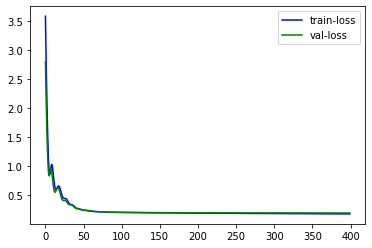

In [126]:
def acuraccy_regression(X, Y):
    with torch.no_grad():
        Y_pred = model(torch.tensor(X, dtype = torch.float32))
    
    Y_label = torch.round(Y_pred)
    confusion_mat = confusion_matrix(Y, Y_label)
    Y_accuracy = torch.sum(Y_label == torch.tensor(Y, dtype = torch.int64)) / Y_pred.shape[0]
    
    return Y_accuracy, confusion_mat


Y_accuracy_train, confusion_mat_train = acuraccy_regression(X_train, Y_train)
print('Training accuracy: {}'.format(Y_accuracy_train))


Y_accuracy_val, confusion_mat_val = acuraccy_regression(X_val, Y_val)
print('Validation accuracy: {}'.format(Y_accuracy_val))

print('Confusion matrix for validation :')
print()
print(confusion_mat_val)
print()
plot_loss(train_loss, 'train-loss', color='blue')
plot_loss(val_loss, 'val-loss', color='green')


### Comparison between regression and classification  problem

Fundamentally, classification is about predicting a label and regression is about predicting a quantity.


Similarities:

- Similar classification score after rounding the regession prediction

- Similar training time

- Same data extraction method for this problem

- If the labels of regression are round up, we can compare classification acuraccy by calculating the percentage of 'right' predictions. This gives us a ~80% acuraccy for both neural networks on both train and validation splits.

Differences:

- Different loss function (Cross Entropy for classification and MSE Loss for Regression)

- Classification is the task of predicting a discrete class label, where regression is the task of predicting a continuous quantity.

- At regression, the predicted values must be round op to labels

Key difference : 

The output layer of the neural network is not similar - for acuraccy there the size is one outputing the closest answer in double format, and for the classifier, the output size is equal to the number of classes and represents the probabilitites that the example is of one of these classes.

This is very important as it explains why regression and classification can't always be used for the same problem :
 
- If the predicted label could not be split in a small number of classes (for example the price), then the classification could not be used 

- If the predicted label would not be a continous output variable, then the regression could not be used (for example classifying animals)

Confusion matrices are similar for the two tasks, and we can see that neither has strange values, and most apartments as classified right, or with difference of +-1





### Data, again

Now, the data is read and will be transformed to feature vectors.

We will predict 'Pret' using all features, as this time, all seem to be correlated with the price.

Suprafata, Nr Camere, Scor - most important features

Sector, Etaj, Total etaje  - less important features

The neural network will learn to differentiate the importance of the features by itself

In [59]:

dataframe = pd.read_csv("Bucharest_HousePriceDataset.csv")
print(dataframe)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


new_dataframe = dataframe[['Nr Camere', 'Suprafata', 'Etaj', 'Total Etaje', 'Sector', 'Scor']]
feature_vector = new_dataframe.to_numpy()


std_scale = StandardScaler().fit(feature_vector)
feature_vector = std_scale.transform(feature_vector)


label_vector = dataframe[['Pret']].to_numpy()

X_train, X_val, Y_train, Y_val = train_test_split(feature_vector, label_vector, test_size = 0.15, shuffle='true')



      Nr Camere  Suprafata  Etaj  Total Etaje  Sector  Scor    Pret
0             4     108.00     2            3       4     5   83000
1             1      41.00     1            8       1     1   39900
2             3      63.52     1            3       2     3   84900
3             1      33.00     3           10       5     1   45500
4             2      62.00     5            9       5     5   54900
...         ...        ...   ...          ...     ...   ...     ...
3524          3     102.00     2            5       1     1  189000
3525          4      96.00     1            3       3     2  200000
3526          1      35.00     1            3       4     5   47000
3527          2      60.00     6            7       1     2   89500
3528          3      80.00     3            5       1     2  139000

[3529 rows x 7 columns]


### Multilayer neural network for price regression


The root mean squared error (RMSE) was chosen, for the price regression, as the MSE provided very large loss values, and the arhitecture is similar to the regression on the number of rooms (with except to features chosen


In [73]:
 class MultiLayerNN(nn.Module):
    def __init__(self, 
                 input_size: int, 
                 hidden_size1: int, 
                 hidden_size2: int, 
                 hidden_size3: int,
                 output_size: int):
      
        super().__init__()

        self._layer1 = nn.Linear(input_size, hidden_size1)
        self._layer2 = nn.Linear(hidden_size1, hidden_size2)
        self._layer3 = nn.Linear(hidden_size2, hidden_size3)
        self._layer4 = nn.Linear(hidden_size3, output_size)

        self._relu = nn.ReLU()
   
    def forward(self, input_layer):

        out_layer1 = self._relu(self._layer1(input_layer))
        out_layer2 = self._layer2(out_layer1)
        out_layer3 = self._layer3(out_layer2)
        out_layer4 = self._layer4(out_layer3)

        return out_layer4



In [109]:

model = MultiLayerNN(6, 240, 216, 96, 1)

print(model)

num_epochs = 700
print_every = 100

train_loss = []
val_loss = []

optim = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.MSELoss()

for i in range(num_epochs):
    model.train()
    optim.zero_grad()
    output = model(torch.tensor(X_train, dtype = torch.float32)).flatten()

    loss = torch.sqrt(criterion(output, torch.tensor(Y_train, dtype = torch.float32).flatten()).flatten())

    loss.backward()
    optim.step()
    
    train_loss.append(loss.detach().numpy())

    if i % print_every == 0 or i == num_epochs - 1:
        print(f'EPOCH {i}:')
        print(f'loss = {loss.item()}')

    model.eval()
    with torch.no_grad():

        output = model(torch.tensor(X_val, dtype = torch.float32)).flatten()
        validation_loss = torch.sqrt(F.mse_loss(output, torch.tensor(Y_val, dtype = torch.float32).flatten()))
        val_loss.append(validation_loss)

MultiLayerNN(
  (_layer1): Linear(in_features=6, out_features=240, bias=True)
  (_layer2): Linear(in_features=240, out_features=216, bias=True)
  (_layer3): Linear(in_features=216, out_features=96, bias=True)
  (_layer4): Linear(in_features=96, out_features=1, bias=True)
  (_relu): ReLU()
)
EPOCH 0:
loss = 115636.6015625
EPOCH 100:
loss = 30320.244140625
EPOCH 200:
loss = 29424.58203125
EPOCH 300:
loss = 28922.369140625
EPOCH 400:
loss = 28268.85546875
EPOCH 500:
loss = 27500.421875
EPOCH 600:
loss = 26480.33984375
EPOCH 699:
loss = 25787.39453125


#### Validation and training average MAE on regression, loss plot

For final acuraccy, the MAE loss was chosen for final results - so this would mean the mean absolute difference of the predicted and the true prices.

However, RMSE was more suitable for train because its bigger penalty of large deviations from answers

tensor(97352.2578)
Training MAE: 16734.689453125
Validation MAE: 18552.873046875



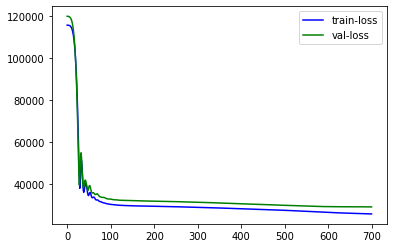

In [110]:
loss = nn.L1Loss()

def acuraccy_regression(X, Y):
    with torch.no_grad():
        Y_pred = model(torch.tensor(X, dtype = torch.float32))

    return loss(Y_pred, torch.tensor(Y, dtype = torch.float32))


# print(torch.sum(torch.tensor(Y_train)) / len(Y_train))

Y_loss_train = acuraccy_regression(X_train, Y_train)
print('Training MAE: {}'.format(Y_loss_train))


Y_loss_val = acuraccy_regression(X_val, Y_val)
print('Validation MAE: {}'.format(Y_loss_val))
print()

plot_loss(train_loss, 'train-loss', color='blue')
plot_loss(val_loss, 'val-loss', color='green')


### What values should the loss have when the predictions are random (when your network is not trained at all)?

When the network is not trained at all, the predicted quantities are random numbers close to zero. 


So in this case, the MAE is the average value of the prices from the dataset. (97352.2578)


In the other two cases:

- Classification : the highest probability given is for 3 rooms (which are the most in the dataset). Then, most apartments are predicted to have 3 room apartment. The cross entropy loss is ~2.1 and converges to ~0.5

- Regression :  The MSE loss is ~3.3 and converges to ~0.2





